In [102]:
import math
import numpy as np
import pandas as pd
from analytic_wfm import peakdetect_spline
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline, UnivariateSpline
from sklearn.neighbors import KernelDensity
from FlowCytometryTools import FCMeasurement
from statsmodels.distributions.empirical_distribution import ECDF

In [103]:
fcs_dir = 'C:/Users/lzoeckler/Desktop/maria_data/Archive_facs'

In [104]:
test = FCMeasurement(ID='', datafile='{}/1.fcs'.format(fcs_dir))
fcs_data = test.data
fcs_channels = test.channels

Encountered an illegal utf-8 byte in the header.
 Illegal utf-8 characters will be ignored.
'utf-8' codec can't decode byte 0xaa in position 101: invalid start byte
Encountered an illegal utf-8 byte in the header.
 Illegal utf-8 characters will be ignored.
'utf-8' codec can't decode byte 0xaa in position 101: invalid start byte


In [105]:
print(len(fcs_data), 'observations')
print(type(fcs_data))
test.channels

10000 observations
<class 'pandas.core.frame.DataFrame'>


,$PnN,$PnR,$PnB,$PnE,$PnS
Channel Number,,,,,
1,FSC-H,1024,16,"[0, 0]",FSC-Height
2,SSC-H,1024,16,"[0, 0]",SSC-Height
3,FL1-H,1024,16,"[4, 0]",FITC
4,FL2-H,1024,16,"[4, 0]",None
5,FL3-H,1024,16,"[4, 0]",None
6,FL1-A,1024,16,"[0, 0]",None
7,FL4-H,1024,16,"[4, 0]",None


In [106]:
fcs_data.head()

,FSC-H,SSC-H,FL1-H,FL2-H,FL3-H,FL1-A,FL4-H
0,395.0,205.0,468.0,416.0,419.0,13.0,451.0
1,237.0,385.0,516.0,453.0,454.0,22.0,470.0
2,190.0,148.0,552.0,477.0,489.0,32.0,527.0
3,487.0,169.0,579.0,529.0,553.0,41.0,553.0
4,419.0,185.0,525.0,465.0,470.0,25.0,512.0


In [107]:
test = fcs_data.loc[fcs_data['FL1-A'] > 0]
test = test[['FSC-H', 'SSC-H', 'FL1-A']]
test['FL1-A'] = test['FL1-A'].apply(math.log)
test.head()

,FSC-H,SSC-H,FL1-A
0,395.0,205.0,2.564949
1,237.0,385.0,3.091042
2,190.0,148.0,3.465736
3,487.0,169.0,3.713572
4,419.0,185.0,3.218876


In [108]:
FSC_ecdf = ECDF(test['FSC-H'])
test['FSC-H'] = FSC_ecdf(test['FSC-H'])
SSC_ecdf = ECDF(test['SSC-H'])
test['SSC-H'] = SSC_ecdf(test['SSC-H'])
test.head()

,FSC-H,SSC-H,FL1-A
0,0.787215,0.648359,2.564949
1,0.366547,0.883353,3.091042
2,0.264206,0.452781,3.465736
3,0.970988,0.536715,3.713572
4,0.853341,0.590336,3.218876


In [109]:
fsc_filt = (.4, .95)
ssc_filt = (.05, .6)

In [147]:
fsc_filter = (test['FSC-H'] >= fsc_filt[0]) & (test['FSC-H'] <= fsc_filt[1])
sub_test = test.loc[fsc_filter]
ssc_filter = (test['SSC-H'] >= ssc_filt[0]) & (test['SSC-H'] <= ssc_filt[1])
sub_test = sub_test.loc[ssc_filter]
sub_test.head()

,FSC-H,SSC-H,FL1-A
4,0.853341,0.590336,3.218876
6,0.915066,0.449080,2.484907
7,0.703481,0.405362,2.639057
8,0.889156,0.494398,3.367296
9,0.585434,0.417167,2.079442


In [148]:
fl1h = sub_test['FL1-A'].as_matrix()

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


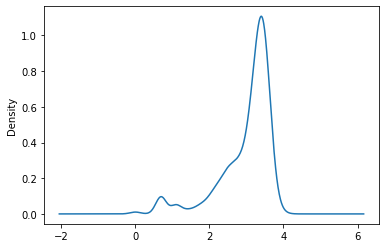

In [149]:
sub_test['FL1-A'].plot.kde()

In [150]:
density = gaussian_kde(fl1h).evaluate(fl1h)
density

array([0.87968401, 0.25872959, 0.2908796 , ..., 1.06886877, 1.10782862,
       0.73468708])

In [151]:
sub_test['density'] = density
d_sum = sub_test['density'].sum()
freq_func = lambda x: x / d_sum
sub_test['freq'] = sub_test['density'].apply(freq_func)
fl1h_max = sub_test['FL1-A'].max()
int_func = lambda x: 100 * (x / fl1h_max)
sub_test['intensity'] = sub_test['FL1-A'].apply(int_func)
sub_test.drop_duplicates(['FL1-A', 'density', 'freq', 'intensity'],
                         inplace=True)
sub_test.sort_values('intensity', inplace=True)
sub_test.head()

,FSC-H,SSC-H,FL1-A,density,freq,intensity
206,0.617547,0.340136,0.000000,0.010357,0.000005,0.000000
22,0.527611,0.266807,0.693147,0.096652,0.000045,16.861310
10,0.472789,0.064026,1.098612,0.052205,0.000024,26.724544
161,0.620948,0.309724,1.386294,0.028889,0.000013,33.722620
508,0.521909,0.320428,1.609438,0.039588,0.000018,39.150749


In [152]:
smooth_spline = CubicSpline(sub_test['intensity'], sub_test['freq'])
spline_derivative = smooth_spline.derivative()

In [153]:
den_x = smooth_spline(sub_test['density'])
den_x

array([4.86079330e-06, 5.51410644e-06, 5.17835586e-06, 5.00159998e-06,
       5.08276353e-06, 5.25935700e-06, 5.48428568e-06, 5.76952960e-06,
       6.03937193e-06, 6.29076512e-06, 6.52868737e-06, 6.72500653e-06,
       6.86336808e-06, 6.96270854e-06, 7.05726761e-06, 7.17524639e-06,
       7.33936846e-06, 7.57227731e-06, 7.89253476e-06, 8.30672753e-06,
       8.80659807e-06, 9.37202321e-06, 9.97567451e-06, 1.05864333e-05,
       1.11715482e-05, 1.16986665e-05, 1.21382919e-05, 1.24663392e-05,
       1.26661502e-05, 1.27295482e-05, 1.26568719e-05, 1.24561737e-05,
       1.21418456e-05, 1.17329164e-05, 1.12512224e-05, 1.07196173e-05,
       1.01603604e-05, 9.59379729e-06, 9.03740409e-06, 8.50522507e-06,
       8.00768273e-06, 7.55170328e-06, 7.14107609e-06, 6.77695838e-06,
       6.45844285e-06, 6.18312161e-06, 5.94759905e-06, 5.74792588e-06,
       5.57994311e-06, 5.43953668e-06, 5.32281195e-06, 5.22620105e-06,
       5.08097328e-06, 5.02716672e-06, 4.85706700e-06])

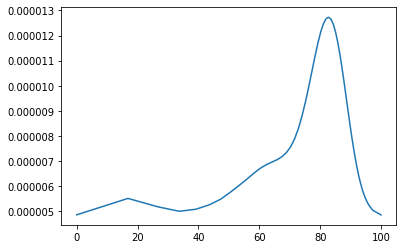

In [154]:
plt.plot(sub_test['intensity'], den_x)

In [155]:
peaks1, properties1 = find_peaks(den_x)
peaks1

array([ 1, 29], dtype=int64)

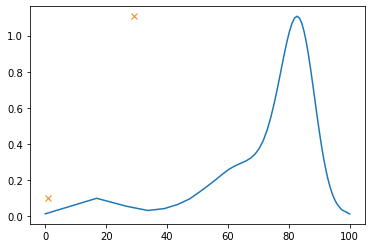

In [156]:
plt.plot(sub_test['intensity'], sub_test['density'])
plt.plot(peaks1, testx[peaks1], "x")

In [72]:
peaks2, properties2 = peakdetect_spline(den_x, sub_test['intensity'])
# peaks2 = np.array(peaks2[0], type=)
# plt.plot(sub_test['intensity'], den_x)
# plt.plot(peaks2, den_x[peaks2], "x")
peaks2

ValueError: No zero crossings found

In [52]:
den_der_x = spline_derivative(sub_test['density'])
den_der_x

array([7.60543348e-06, 7.53603291e-06, 7.57174839e-06, 7.59050898e-06,
       7.58189797e-06, 7.56314144e-06, 7.53920933e-06, 7.50879195e-06,
       7.47994653e-06, 7.45301111e-06, 7.42746333e-06, 7.40634172e-06,
       7.39143317e-06, 7.38071766e-06, 7.37050891e-06, 7.35775941e-06,
       7.34000053e-06, 7.31475261e-06, 7.27994713e-06, 7.23477861e-06,
       7.18003176e-06, 7.11778979e-06, 7.05096264e-06, 6.98294324e-06,
       6.91738847e-06, 6.85799623e-06, 6.80821412e-06, 6.77091734e-06,
       6.74813672e-06, 6.74089855e-06, 6.74919563e-06, 6.77207502e-06,
       6.80781078e-06, 6.85412603e-06, 6.90843186e-06, 6.96805563e-06,
       7.03043785e-06, 7.09328403e-06, 7.15466545e-06, 7.21306975e-06,
       7.26740756e-06, 7.31698507e-06, 7.36145347e-06, 7.40074606e-06,
       7.43501176e-06, 7.46455190e-06, 7.48976452e-06, 7.51109836e-06,
       7.52901724e-06, 7.54397430e-06, 7.55639467e-06, 7.56666523e-06,
       7.58208797e-06, 7.58779714e-06, 7.60582820e-06])

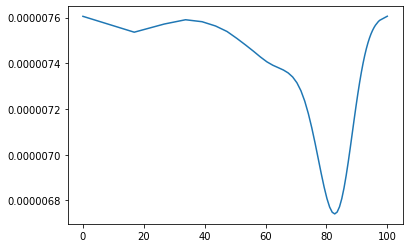

In [53]:
plt.plot(sub_test['intensity'], den_der_x)